In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report
import warnings
warnings.filterwarnings('ignore')

In [2]:
data1 = pd.read_csv('Dataset3/Youtube01-Psy.csv')
data2 = pd.read_csv('Dataset3/Youtube02-KatyPerry.csv')
data3 = pd.read_csv('Dataset3/Youtube03-LMFAO.csv')
data4 = pd.read_csv('Dataset3/Youtube04-Eminem.csv')
data5 = pd.read_csv('Dataset3/Youtube05-Shakira.csv')


In [3]:
data = pd.concat([data1, data2, data3, data4, data5])
data.drop_duplicates()
data.reset_index()
data.shape

(1956, 5)

In [4]:
data.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1


In [5]:
data['CLASS'].value_counts()

CLASS
1    1005
0     951
Name: count, dtype: int64

In [6]:
data.isna().sum()

COMMENT_ID      0
AUTHOR          0
DATE          245
CONTENT         0
CLASS           0
dtype: int64

#### Function to convert words into tokens

In [7]:
def get_sequences(texts, tokenizer, train = True, max_seq_len = None):
    sequence = tokenizer.texts_to_sequences(texts)
    if train == True:
        max_seq_len = np.max(list(map(len, sequence)))
    sequence = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen = max_seq_len, padding = 'post')
    return sequence

In [8]:
def preprocessing(df):
    df = df.copy()
    # Splitting Data
    X = df['CONTENT']
    Y = df['CLASS']
    # Train_Test_Split
    x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.30, shuffle = True, random_state = 1)
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(x_train)
    print(f'Vocab Length : {len(tokenizer.word_index)+1}')
    x_train = get_sequences(texts = x_train, tokenizer = tokenizer, train = True)
    x_test = get_sequences(texts = x_test, tokenizer = tokenizer, train = False, max_seq_len = x_train.shape[1])
    print(f'\nSequence Length : {x_train.shape[1]}')
    return x_train, x_test, y_train, y_test

In [9]:
x_train, x_test, y_train, y_test = preprocessing(data)

Vocab Length : 3821

Sequence Length : 227


#### Training

In [10]:
inputs = tf.keras.Input(shape = (227,))
x = tf.keras.layers.Embedding(input_dim = 3821, output_dim = 300)(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128 , activation = 'relu')(x)
x = tf.keras.layers.Dense(128 , activation = 'relu')(x)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
model = tf.keras.Model(inputs = inputs, outputs = outputs)
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy', tf.keras.metrics.AUC(name = 'auc')]
)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227)]             0         
                                                                 
 embedding (Embedding)       (None, 227, 300)          1146300   
                                                                 
 flatten (Flatten)           (None, 68100)             0         
                                                                 
 dense (Dense)               (None, 128)               8716928   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,879,869
Trainable params: 9,879,869
Non-train

In [11]:
history = model.fit(
    x_train,
    y_train,
    validation_split = 0.2,
    batch_size = 32,
    epochs = 100,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor = 'val_loss',
            patience = 5,
            restore_best_weights = True
        )
    ]
)

Epoch 1/100
35/35 [==============================] - 9s 228ms/step - loss: 0.6275 - accuracy: 0.6584 - auc: 0.7164 - val_loss: 0.3894 - val_accuracy: 0.8321 - val_auc: 0.9542
Epoch 2/100
35/35 [==============================] - 8s 217ms/step - loss: 0.2227 - accuracy: 0.9205 - auc: 0.9743 - val_loss: 0.1739 - val_accuracy: 0.9343 - val_auc: 0.9820
Epoch 3/100
35/35 [==============================] - 8s 223ms/step - loss: 0.0698 - accuracy: 0.9790 - auc: 0.9974 - val_loss: 0.2173 - val_accuracy: 0.9161 - val_auc: 0.9823
Epoch 4/100
35/35 [==============================] - 8s 227ms/step - loss: 0.0257 - accuracy: 0.9909 - auc: 0.9996 - val_loss: 0.1775 - val_accuracy: 0.9453 - val_auc: 0.9813
Epoch 5/100
35/35 [==============================] - 8s 217ms/step - loss: 0.0101 - accuracy: 0.9982 - auc: 1.0000 - val_loss: 0.1727 - val_accuracy: 0.9453 - val_auc: 0.9766
Epoch 6/100
35/35 [==============================] - 7s 214ms/step - loss: 0.0039 - accuracy: 1.0000 - auc: 1.0000 - val_loss

#### Result

In [12]:
results = model.evaluate(x_test, y_test, verbose = 0)
print(f'Accuracy : {round(results[1]*100, 4)}%')
print(f'AUC : {round(results[2],3)}')

Accuracy : 92.1635%
AUC : 0.974


#### Confusion Matrix and Classifcation Report

19/19 [==============================] - 0s 13ms/step


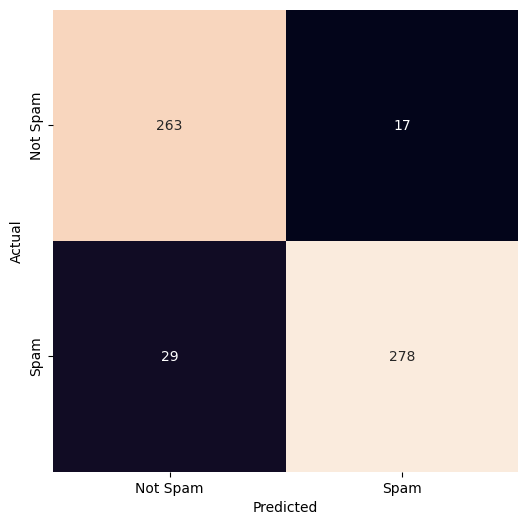

Classification Report ------------------->
              precision    recall  f1-score   support

    Not Spam       0.90      0.94      0.92       280
        Spam       0.94      0.91      0.92       307

    accuracy                           0.92       587
   macro avg       0.92      0.92      0.92       587
weighted avg       0.92      0.92      0.92       587



In [13]:
y_pred = np.squeeze(model.predict(x_test) >= 0.5).astype(np.int)
cm = confusion_matrix(y_test, y_pred,labels = [0,1] )
clr = classification_report(y_test, y_pred, labels = [0,1], target_names = ['Not Spam', "Spam"])
plt.figure(figsize = (6,6))
sns.heatmap(cm, annot = True, fmt = 'g', cbar = False)
plt.xticks(ticks = [0.5, 1.5], labels = ['Not Spam', "Spam"])
plt.yticks(ticks = [0.5, 1.5], labels = ['Not Spam', "Spam"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(f'Classification Report ------------------->\n{clr}')

#### Prueba Predicción

In [14]:
response = model.predict(x_test)

contador = 1
prediccion = []

for i in response:
    # Se imprime los primeros 50 datos de prueba
    if contador <= 50:
       # Se cargan los porcentajes a un vector 
        print("Porcentaje Spam: ", i)
        prediccion.append(i)
        contador = contador + 1


19/19 [==============================] - 0s 13ms/step
Porcentaje Spam:  [0.99954766]
Porcentaje Spam:  [0.00100794]
Porcentaje Spam:  [0.99844563]
Porcentaje Spam:  [0.99999243]
Porcentaje Spam:  [0.00737617]
Porcentaje Spam:  [0.00083679]
Porcentaje Spam:  [0.00079444]
Porcentaje Spam:  [0.00372906]
Porcentaje Spam:  [0.9999158]
Porcentaje Spam:  [0.99999183]
Porcentaje Spam:  [0.99999183]
Porcentaje Spam:  [0.9999982]
Porcentaje Spam:  [0.00057817]
Porcentaje Spam:  [0.00962861]
Porcentaje Spam:  [0.99999183]
Porcentaje Spam:  [0.9588436]
Porcentaje Spam:  [0.06576642]
Porcentaje Spam:  [0.6163081]
Porcentaje Spam:  [0.00124328]
Porcentaje Spam:  [0.9992678]
Porcentaje Spam:  [0.01924056]
Porcentaje Spam:  [0.9998314]
Porcentaje Spam:  [0.00131005]
Porcentaje Spam:  [0.9820925]
Porcentaje Spam:  [0.0019065]
Porcentaje Spam:  [0.00180402]
Porcentaje Spam:  [0.00789891]
Porcentaje Spam:  [0.4723067]
Porcentaje Spam:  [0.00081872]
Porcentaje Spam:  [0.9951171]
Porcentaje Spam:  [0.00283

#### Referencia

https://www.kaggle.com/code/johnybhiduri/youtube-spam-comments-using-tensorflow

